In [6]:
import numpy as np
import os
import sys
from simulation import heart_rate
from matplotlib import pyplot as plt
from scipy import signal as ss
import utils.signal as sp
from utils.plots import time_plot
%matplotlib widget
import ipywidgets as widgets
from utils.plots import tinyprobe_visualize

In [104]:
def get_raw(file_name):
    data_file = np.load(file_name)
    return data_file

def get_wall_diameter(data, fs=1, oversampling_factor=10,
                      arterie_range=(0,-1), axis=-1, plot = False):
    
    data_filt = sp.butter_bp(data, fc=(1.2e6,2.5e6), fs=fs, axis = axis,order=2)
    if plot:
        plt.grid(True)
        plt.plot(data_filt[0,:,arterie_range[0]:arterie_range[-1]].T)
    data_hilbert = ss.hilbert(data_filt,axis=axis)
    envelope_arterie_range = np.abs(data_hilbert[:,:,arterie_range[0]:arterie_range[-1]])
        
    envelope_os = ss.resample(envelope_arterie_range,
                              envelope_arterie_range.shape[-1]*oversampling_factor,
                              axis = axis)
    mm_per_sample = 1_500/2 /fs *1_000/oversampling_factor
    
    def peak_finder(a): #find the two peaks with the maximum prominences
        peak = ss.find_peaks(a,height=np.max(a)/4,prominence=0)
        if len(peak[0])==0:
            return np.array([0,0])
        elif len(peak[0])==1:
            return np.array([peak[0][0],0])
        elif len(peak[0])==1:
            return peak[0]
        else:
            idx = np.argsort(peak[1]["prominences"])[::-1][:2]
            return peak[0][idx]
        
    peaks = np.apply_along_axis(peak_finder, -1, envelope_os)
    if plot:
        print(envelope_os.shape)
        print(peaks[1,0,:]+arterie_range[0])
        plt.plot(np.arange(0,len(envelope_os[0,0,:]))*1/oversampling_factor,envelope_os[1,:,:].T)
        plt.plot(peaks[0,0,:]/oversampling_factor,envelope_os[0,0,peaks[0,0,:]],'rx')
        plt.plot(peaks[0,1,:]/oversampling_factor,envelope_os[0,1,peaks[0,1,:]],'bx')
        #plt.plot(peaks[0,1,:]/oversampling_factor,[0,0],'gx')
    
    return np.abs(np.diff(peaks,axis=-1)).squeeze()*mm_per_sample

(195, 32, 511)
(195, 32, 1500)
[ 621 1114]


0

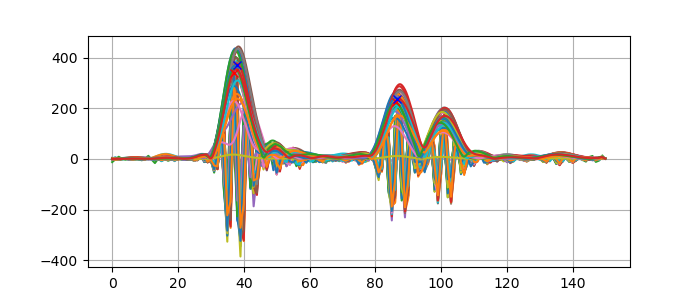

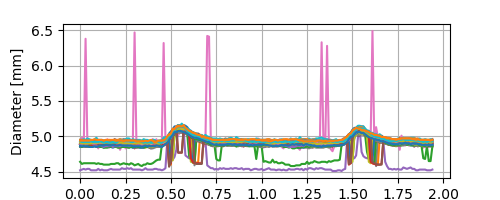

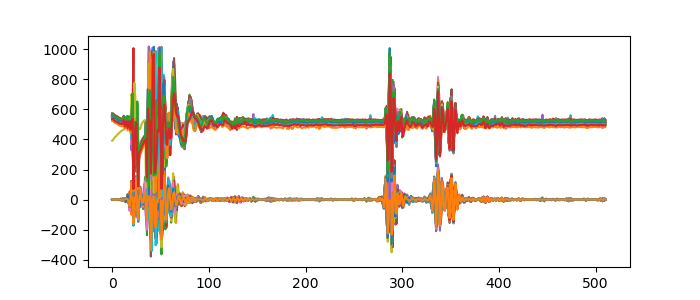

In [113]:
plt.close("all")
plt.figure(figsize=(7,3))
#TinyProbe_data2_21.02.2024
decimation = 1
raw_data = get_raw(f"TinyProbe_data3_6.03.2024/4.npy")[5:,:,::decimation]
fs=7.5e6/decimation
print(raw_data.shape)
wall_dist = get_wall_diameter(raw_data[:,:,:], fs=fs, 
                              arterie_range=(250,400), axis=-1, plot=True,
                             oversampling_factor=10*decimation)
data_filt = sp.butter_bp(raw_data, fc=(1.2e6,2.25e6), fs=fs, axis = -1,order=2)
#sp.remez_bp(raw_data, fc=(1.2e6,2.25e6), fs=fs, axis = -1,
                           # trans_width=fs/40,order=32)
FPS = 100
plt.figure(figsize=(5,2))
time_plot(wall_dist, dt=1/FPS)
plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")
plt.figure(figsize=(7,3))
plt.plot(data_filt[0,:,:].T)
plt.plot(raw_data[0,:,:].T)
0

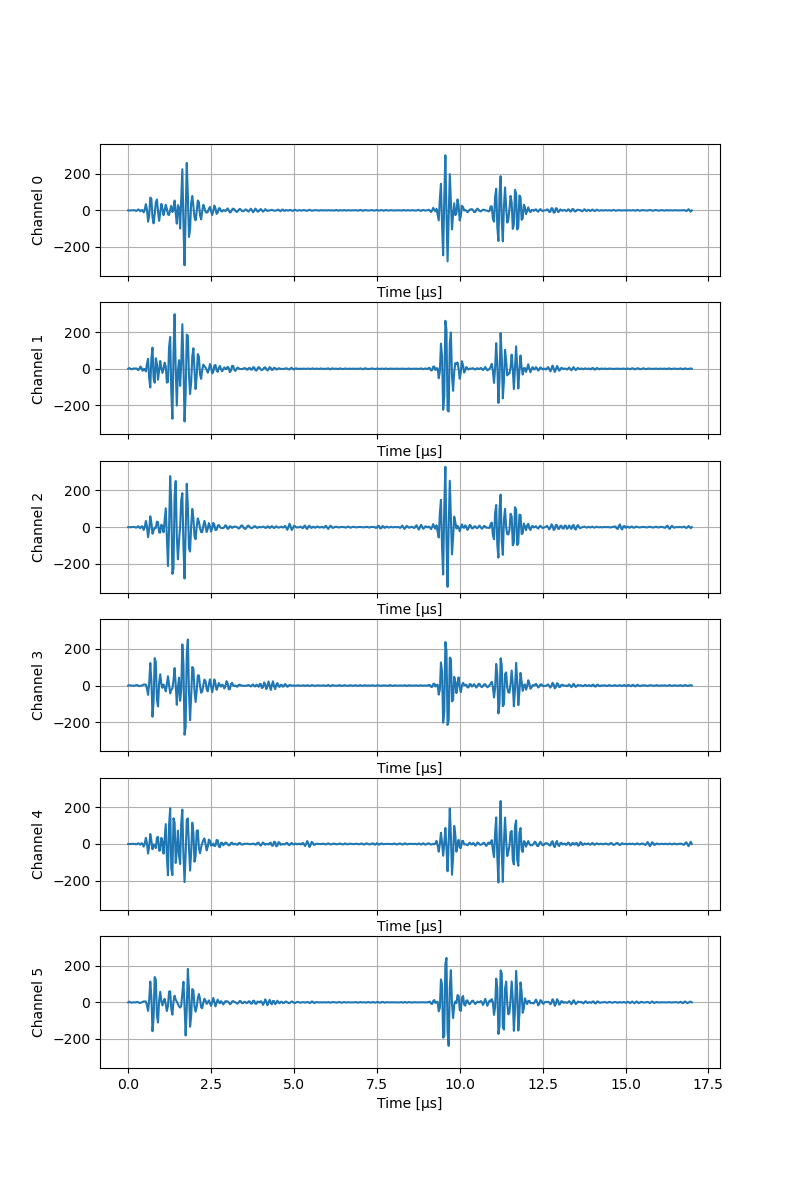

interactive(children=(IntSlider(value=0, description='frame', max=194), Output()), _dom_classes=('widget-inter…

In [116]:
tinyprobe_visualize(data_filt[:,:6,:],fs=30e6)
#plt.tight_layout()

Text(0, 0.5, 'Diameter [mm]')

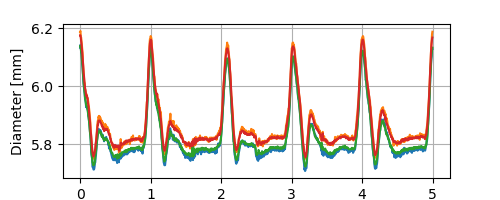

In [100]:
try:
    dist_memory
except:
    dist_memory = []
dist_memory += [wall_dist]
plt.figure(figsize=(5,2))
for wall_dist in dist_memory:
    time_plot(wall_dist, dt=1/FPS)
plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")

In [95]:
dist_memory = []